In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue20cs344-nam-assignment-2/edgelist.csv
/kaggle/input/ue20cs344-nam-assignment-2/sample_submission.csv
/kaggle/input/ue20cs344-nam-assignment-2/node_data.csv
/kaggle/input/ue20cs344-nam-assignment-2/features.pt


## **INSTALLING LIBRARY**

In [4]:
!pip install node2vec
!pip install torch-geometric
!pip install torch

  Preparing metadata (setup.py) ... done
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=a363b5965a26aad225c6d40b8310d96837545d63d81d6331b41259ab70022e15
  Stored in directory: /root/.cache/pip/wheels/41/d8/5d/28571981b2dc5a7003e03031a9f42c9a68f323b8fb1ddbb341
Successfully built node2vec
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909879 sha256=2984ada1633754e25a631fb299c55a91c901d0202e06579172e0957ed4aee911
  Stored in directory: /root/.cache/pip/wheels/47/16/75/ac3099e3ea0348d3e241a8230d1fe50b202badaf5d89ae1825
Successfully built torch-geometric


## **IMPORTING LIBRARY**

In [5]:
import networkx as nx
from networkx.algorithms import centrality
import matplotlib.pyplot as plt
import torch
#from node2vec import Node2Vec
from torch_geometric.utils import from_networkx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder

In [6]:
# Set the maximum rows to read from the CSV files
max_rows = None

## **Read The Dataset**

In [15]:
# Read the edge list and node data CSV files into dataframes, using only the necessary columns
edge_df = pd.read_csv("/kaggle/input/ue20cs344-nam-assignment-2/edgelist.csv", nrows=max_rows)
node_df = pd.read_csv("/kaggle/input/ue20cs344-nam-assignment-2/node_data.csv", nrows=max_rows)
node_features = torch.load('/kaggle/input/ue20cs344-nam-assignment-2/features.pt')

## **Creating a networkx graph from a given edge list and node list**

In [16]:
# Add branch information to each node in the node data dataframe, using the "id" column as the node identifier
branch_dict = dict(zip(node_df["id"], node_df["branch"]))

# Create the graph directly from the edge list dataframe, using the "source" and "target" columns
G = nx.from_pandas_edgelist(edge_df, source="source", target="target", create_using=nx.Graph())

# Add branch information to each node in the graph, using the branch_dict dictionary
nx.set_node_attributes(G, branch_dict, "branch")

# Define the color map for each branch
color_map = {"ECE": "red", "EEE": "purple", "CSE": "green"}

# Create a list of node colors based on the branch attribute of each node
node_colors = [color_map.get(G.nodes[node].get("branch", ""), "white") for node in G.nodes()]

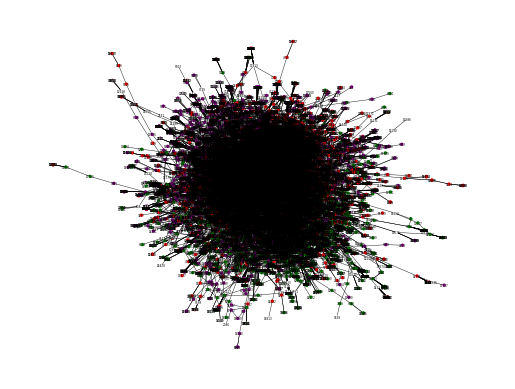

In [17]:
# Draw the graph with node colors and smaller node size
#pos = nx.spring_layout(G)
#nx.draw_networkx(G, pos, node_color=node_colors, node_size=2,width=0.3 ,with_labels=True, font_size=2)
#plt.axis("off")
#plt.show()

## **Generate features**

In [18]:
# create a graph from the given edge list and node list
G = nx.Graph()
edges = [(edge[0], edge[1]) for edge in edge_df]
G.add_edges_from(edges)
nodes = [node[0] for node in node_df]
for node in nodes:
    G.add_node(node)

# calculate betweenness centrality for each node
bc = nx.betweenness_centrality(G)

# print the results
for node, centrality in bc.items():
    print(f"Node {node}: {centrality}")

Node s: 0.0
Node o: 0.0
Node t: 0.0
Node a: 0.0
Node i: 0.0
Node b: 0.0


In [19]:
le = LabelEncoder()
node_df['branch']=le.fit_transform(node_df['branch'])
G=nx.from_pandas_edgelist(edge_df,'source','target')

## **Converting networkx graph to Pytorch geometric graph**

In [20]:
# Convert NetworkX graph to Pytorch Geometric graph
data = from_networkx(G)

# Add node features to Pytorch Geometric graph
data.x = node_features

## **For the pytorch geometric graph, add the features given in features.pt**

In [21]:
# Add node features to Pytorch Geometric graph
data.x = node_features
# Generate degree feature
degrees = np.array([G.degree(node) for node in G.nodes()])
degree_feature = torch.tensor(degrees, dtype=torch.float).reshape(-1, 1)

# Add degree feature to Pytorch Geometric graph
data.x = torch.cat((data.x, degree_feature), dim=1)

## **Use a GNN (ex: GCN) and train on the graph. Use the train and test masks as needed when defining the accuracy and to predict for the GNNs**

In [29]:
# Create a networkx graph from the edge list
G = nx.from_pandas_edgelist(edge_df, 'source', 'target')

# Create a Pytorch Geometric Data object from the networkx graph
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = node_features
y = torch.tensor(node_df['branch'].values, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

In [30]:
# Define the GCN model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [31]:
# Initialize the model, optimizer and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(node_features.shape[1], 16, node_df['branch'].nunique()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()


In [32]:
# Split the train and test mask
train_mask = node_df['train_mask'].values
test_mask = node_df['test_mask'].values

In [33]:
# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[train_mask], data.y[train_mask].to(device))
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(200):
    loss = train()
    print('Epoch: {}, Loss: {}'.format(epoch, loss))

Epoch: 0, Loss: 1.3831775188446045
Epoch: 1, Loss: 1.3601292371749878
Epoch: 2, Loss: 1.3335422277450562
Epoch: 3, Loss: 1.3046032190322876
Epoch: 4, Loss: 1.2780624628067017
Epoch: 5, Loss: 1.249990701675415
Epoch: 6, Loss: 1.2227592468261719
Epoch: 7, Loss: 1.1971899271011353
Epoch: 8, Loss: 1.1761778593063354
Epoch: 9, Loss: 1.1519275903701782
Epoch: 10, Loss: 1.1307135820388794
Epoch: 11, Loss: 1.1114747524261475
Epoch: 12, Loss: 1.0940566062927246
Epoch: 13, Loss: 1.0763933658599854
Epoch: 14, Loss: 1.0592036247253418
Epoch: 15, Loss: 1.043576955795288
Epoch: 16, Loss: 1.0321131944656372
Epoch: 17, Loss: 1.0162353515625
Epoch: 18, Loss: 1.0019203424453735
Epoch: 19, Loss: 0.9892871975898743
Epoch: 20, Loss: 0.9752815961837769
Epoch: 21, Loss: 0.9595016241073608
Epoch: 22, Loss: 0.9574854969978333
Epoch: 23, Loss: 0.9448384642601013
Epoch: 24, Loss: 0.9292940497398376
Epoch: 25, Loss: 0.9207956790924072
Epoch: 26, Loss: 0.9134750366210938
Epoch: 27, Loss: 0.9024698734283447
Epoch: 

## **The final output required is the prediction value of branch for the test nodes only**

In [35]:
# Evaluate the model
model.eval()
_, pred = model(data.x.to(device), data.edge_index.to(device)).max(dim=1)
test_preds = pred[test_mask].detach().cpu().numpy()
test_ids = node_df['id'][test_mask].values



In [36]:
# Decode the branch labels
test_preds = le.inverse_transform(test_preds)

In [37]:
# Create the submission file
submission_df = pd.DataFrame({'id': test_ids, 'branch': test_preds})
submission_df.to_csv('submission.csv', index=False)

# Print submission file
print(submission_df.head())

   id branch
0   4    ECE
1  22    EEE
2  29    ECE
3  32    ECE
4  34    CSE
